# Working - Foster Care Analysis
This file is a working document for the Foster Care Analysis project. This is not the final version of the project. The final version will be published in a separate file.

In [1]:
from google.cloud import storage
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from dotenv import load_dotenv
import os

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.preprocessing import RobustScaler
import tensorflow as tf

2024-04-14 21:30:44.922619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# import function files and environment variables
import utils

# Load the .env file
load_dotenv()

# Connect to the Google Cloud Storage bucket
service_account_path = 'GOOGLE_APPLICATION_CREDENTIALS.json'
client = storage.Client.from_service_account_json(service_account_path)
bucket_name = 'foster-care'
bucket = client.get_bucket(bucket_name)

In [3]:
# reload th imports
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/topanga37/github/DATASCI207_Sec03/Final Project/utils.py'>

## Read Data

In [4]:
# Read in Variable Values and Variable Definitions
variable_values_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variable Values.xlsx')) # Mapping
variables_df = pd.read_excel(utils.read_cloud_data(bucket, 'FC Variables.xlsx')) # Variable Definitions

In [5]:
# Read in the raw data from the Google bucket
raw_df_2016 = pd.read_sas(utils.read_cloud_data(bucket, '2016.sas7bdat'), format='sas7bdat') 
raw_df_2017 = pd.read_sas(utils.read_cloud_data(bucket, '2017.sas7bdat'), format='sas7bdat')
raw_df_2018 = pd.read_sas(utils.read_cloud_data(bucket, '2018.sas7bdat'), format='sas7bdat') 
raw_df_2019 = pd.read_sas(utils.read_cloud_data(bucket, '2019.sas7bdat'), format='sas7bdat') 
raw_df_2020 = pd.read_sas(utils.read_cloud_data(bucket, '2020.sas7bdat'), format='sas7bdat')
raw_df_2021 = pd.read_sas(utils.read_cloud_data(bucket, '2021.sas7bdat'), format='sas7bdat') 

In [6]:
# Make the raw datafile readable using the 'make readable' function in utils.py 
df_2016 = utils.make_readable(raw_df_2016.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2017 = utils.make_readable(raw_df_2017.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2018 = utils.make_readable(raw_df_2018.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2019 = utils.make_readable(raw_df_2019.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2020 = utils.make_readable(raw_df_2020.rename({'FY':'DataYear'}, axis=1), variable_values_df)
df_2021 = utils.make_readable(raw_df_2021.rename({'FY':'DataYear'}, axis=1), variable_values_df)

# Filter and Clean Data

In [7]:
# Bring all data together
all_records = pd.concat([df_2016, df_2017, df_2018, df_2019, df_2020, df_2021], axis=0)
print(f"All Records: {all_records.shape}")

All Records: (3974699, 59)


In [8]:
# Keep only the cases where the child has exited foster care
records_df = all_records[all_records['EXITED'] == 1]
print(f"Filtering for Exited Only: {records_df.shape}")

# Keep only kids who are 18 years old or older by 2021 so we know they never re-entered foster care
records_df = records_df[records_df['age2021'] >= 18]
print(f"Filtering for 18 YO and Older: {records_df.shape}")
records_df.drop(columns=['age2021'], inplace=True)

# Keep only records where child is under 21 years old (when foster care ends)
records_df = records_df[records_df['AGEATEND'] <= 21]
print(f"Filtering for Under 22 YO: {records_df.shape}")

Filtering for Exited Only: (1440340, 59)
Filtering for 18 YO and Older: (1440313, 59)
Filtering for Under 22 YO: (1440247, 58)


In [9]:
# Create new variables to use for the reentry function
num_yrs_df = records_df[['RECNUMBR', 'DATAYEAR']].reset_index().groupby(['RECNUMBR', 'DATAYEAR']).count().reset_index()
num_yrs_df.columns = ['RECNUMBR', 'DATAYEAR', 'COUNT']
total_yrs = num_yrs_df.groupby('RECNUMBR')['COUNT'].count().reset_index().rename({'COUNT':'TOTAL_YRS'}, axis=1)
num_yrs_df = num_yrs_df.pivot(index='RECNUMBR', columns='DATAYEAR', values='COUNT').reset_index()
num_yrs_df = num_yrs_df.merge(total_yrs, on='RECNUMBR', how='left').sort_values('TOTAL_YRS', ascending=False).reset_index(drop=True)

In [10]:
# Run the reentry function to get a new column that shows if the individual reentered the system through the timeframe
reentry_check_df = utils.mark_reentries(num_yrs_df.fillna(0), 2016, 2021)

In [11]:
# Merge the original dataset with the new dataset created from the reentry function
records_df = records_df.merge(reentry_check_df, on='RECNUMBR', how='left')
records_df.head()

,DATAYEAR,RECNUMBR,MR,VISHEAR,PHYDIS,EMOTDIST,OTHERMED,TOTALREM,NUMPLEP,PHYABUSE,SEXABUSE,NEGLECT,AAPARENT,DAPARENT,AACHILD,DACHILD,CHILDIS,CHBEHPRB,PRTSDIED,PRTSJAIL,NOCOPE,ABANDMNT,RELINQSH,HOUSING,IVEFC,IVEAA,IVAAFDC,IVDCHSUP,XIXMEDCD,SSIOTHER,NOA,FCMNTPAY,SETTINGLOS,PREVIOUSLOS,LIFELOS,AGEATLATREM,AGEATEND,INATSTART,INATEND,EXITED,SERVED,ISWAITING,ISTPR,AGEDOUT,State,FIPSCode,Sex,AgeAdopt,removalManner,currentPlacementSetting,OutOfStatePlacement,caseGoal,caretakerFamilyStructure,fosterFamilyStructure,dischargeReason,raceEthnicity,everAdopted,diagnosedDisability,2016,2017,2018,2019,2020,2021,TOTAL_YRS,Reentry
0,2016,b'000000006031',0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,488.0,487.0,NaN,727.0,10.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,"Foster home, non-relative",Yes,Live with other relative(s),Single female,NaN,Living with other relative(s),"Non-Hispanic (NH), White","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False
1,2016,b'000000009831',0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,66.0,567.0,637.0,17.0,17.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,"Jefferson, AL",Female,Not applicable,Court ordered,Group home,No,"Reunify with parent, principal caretaker",Married couple,Not applicable,Emancipation,"Non-Hispanic (NH), White","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False
2,2016,b'000000014871',0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,501.0,85.0,NaN,2417.0,13.0,20.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Female,Not applicable,Court ordered,Runaway,No,Emancipation,Married couple,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False
3,2016,b'000000018834',0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,NaN,286.0,17.0,18.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Alabama,Fewer than 1000 cases in the County,Female,Not applicable,Court ordered,Trial home visit,No,"Reunify with parent, principal caretaker",Single female,Not applicable,"Reunified with parent, primary caretaker","NH, Black","No, has never been legally adopted",No,1.0,1.0,0.0,0.0,0.0,0.0,2,False
4,2016,b'000000026281',0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,904.0,NaN,1995.0,15.0,21.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,Alabama,Fewer than 1000 cases in the County,Male,Not applicable,Court ordered,Supervised independent living,No,Emancipation,Single female,Not applicable,Emancipation,"NH, Black","No, has never been legally adopted",No,1.0,0.0,0.0,0.0,0.0,0.0,1,False


In [12]:
# Run the remove_nan_values function to deal with all of the NaN values
records_df = utils.remove_nan_values(records_df)

Total Null Values: 0
Total Records: 1440247
Total Columns: 66


In [13]:
# Only keep data for the year 2016; this allows for us to keep track of whether or not the individual reentered during the 5 years following
records_df = records_df.loc[(records_df['DATAYEAR'] == 2016)]

In [14]:
# Create label for if they have reunified, set equal to 0
records_df['reunified'] = 0

# Change values for that feature to 1 if they exited the system to be reunified with their parent or primary caretaker
records_df.loc[(records_df['EXITED'] == 1) & (records_df['dischargeReason'] == 'Reunified with parent, primary caretaker'), 'reunified'] = 1

In [15]:
# See how many records were unsuccessfull reunifications, i.e. the reunified but they reentered the system in later years
print(f"Unsuccuessful reunifications: {len(records_df[(records_df['Reentry'] == True) & (records_df['reunified'] == 1)])}")

Unsuccuessful reunifications: 14794


In [16]:
# Change those values AGAIN if they had an unsuccessful reunification
records_df.loc[(records_df['Reentry'] == True) & (records_df['reunified'] == 1), 'reunified'] = 0

In [17]:
# Drop unnecessary columns that were used to create the binary reunification feature
records_df = records_df.drop(columns=['EXITED', 'INATEND', 'DATAYEAR', '2016', '2017', '2018', '2019', '2020', '2021', 'Reentry']) # drop these, all are 1 now

# Visualizing the data

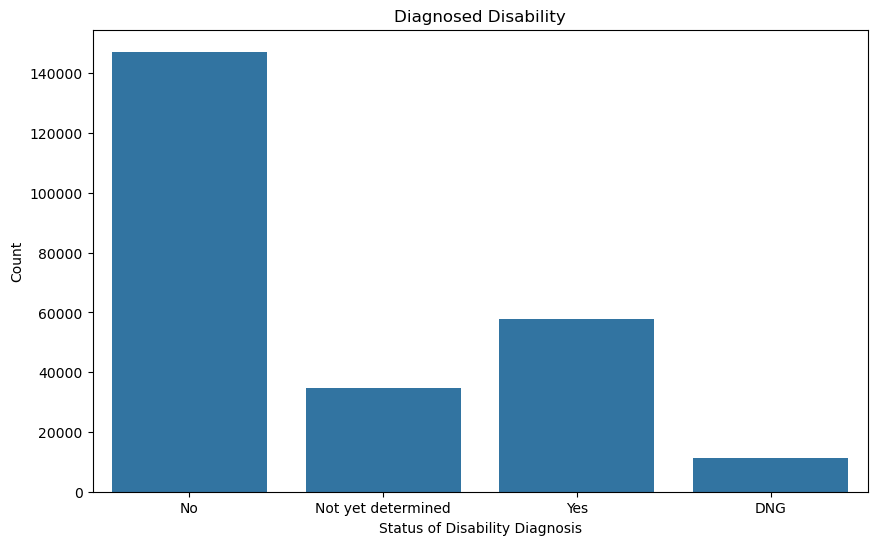

In [18]:
# Bar graph for disagnosed disability
plt.figure(figsize=(10, 6))
sns.countplot(x='diagnosedDisability', data=records_df)
plt.title('Diagnosed Disability')
plt.xlabel('Status of Disability Diagnosis')
plt.ylabel('Count')
plt.show()

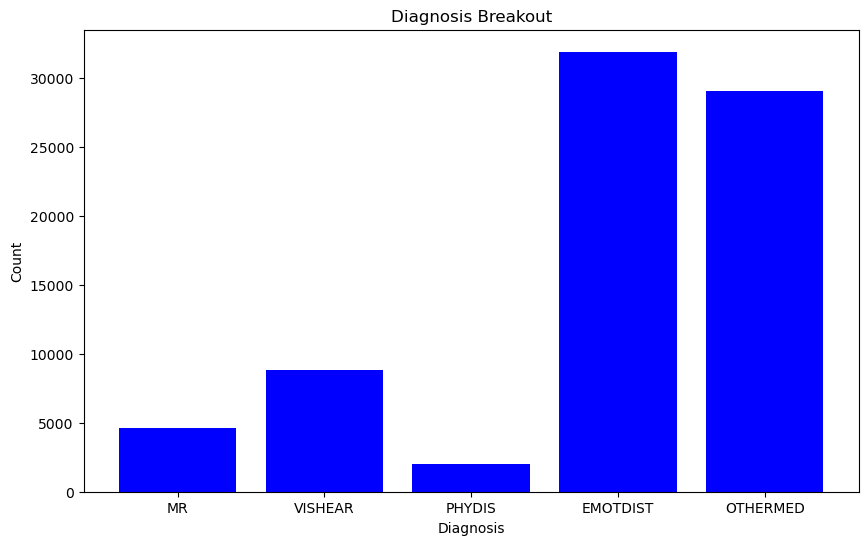

In [19]:
# Bar graph for Diagnosis Break out 
# Bar graph shows the numbers of positive (1) for 'MR', 'VISHEAR', 'PHYDIS', 'EMOTDIST', 'OTHERMED'
sub_df_diag = records_df[['MR', 'VISHEAR', 'PHYDIS', 'EMOTDIST', 'OTHERMED']] 
counts = sub_df_diag.apply(pd.Series.value_counts)
plt.figure(figsize=(10, 6))
plt.bar(counts.columns, counts.iloc[1], color='blue')
plt.title('Diagnosis Breakout')
plt.ylabel('Count')
plt.xlabel('Diagnosis')
plt.show()


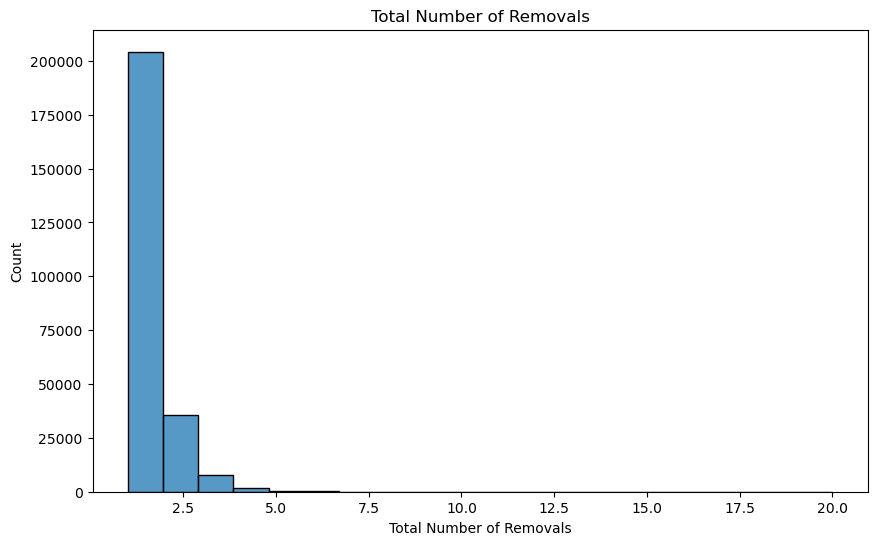

In [20]:
# Histogram of total number of removals (TOTALREM)
plt.figure(figsize=(10, 6))
sns.histplot(records_df['TOTALREM'], bins=20)
plt.title('Total Number of Removals')
plt.xlabel('Total Number of Removals')
plt.ylabel('Count')
plt.show() 

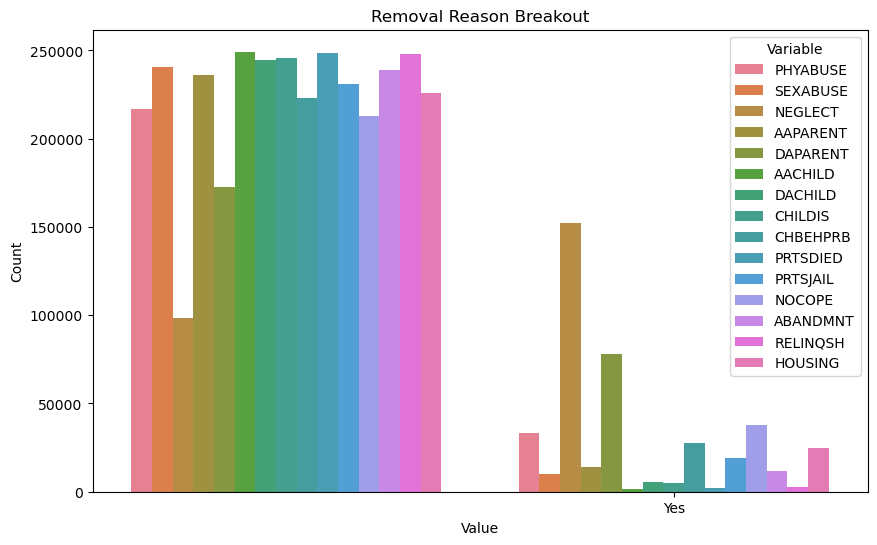

In [21]:
# Bar Graph for Removal Reason 
sub_df_rem = records_df[['PHYABUSE', 'SEXABUSE', 'NEGLECT', 'AAPARENT',
       'DAPARENT', 'AACHILD', 'DACHILD', 'CHILDIS', 'CHBEHPRB', 'PRTSDIED',
       'PRTSJAIL', 'NOCOPE', 'ABANDMNT', 'RELINQSH', 'HOUSING']]
sub_df_rem = sub_df_rem.melt(var_name='Variable', value_name='Value')
plt.figure(figsize=(10, 6))
sns.countplot(x='Value', hue='Variable', data=sub_df_rem)
plt.title('Removal Reason Breakout')
plt.ylabel('Count')
plt.xticks([1], ['Yes'])
plt.show()

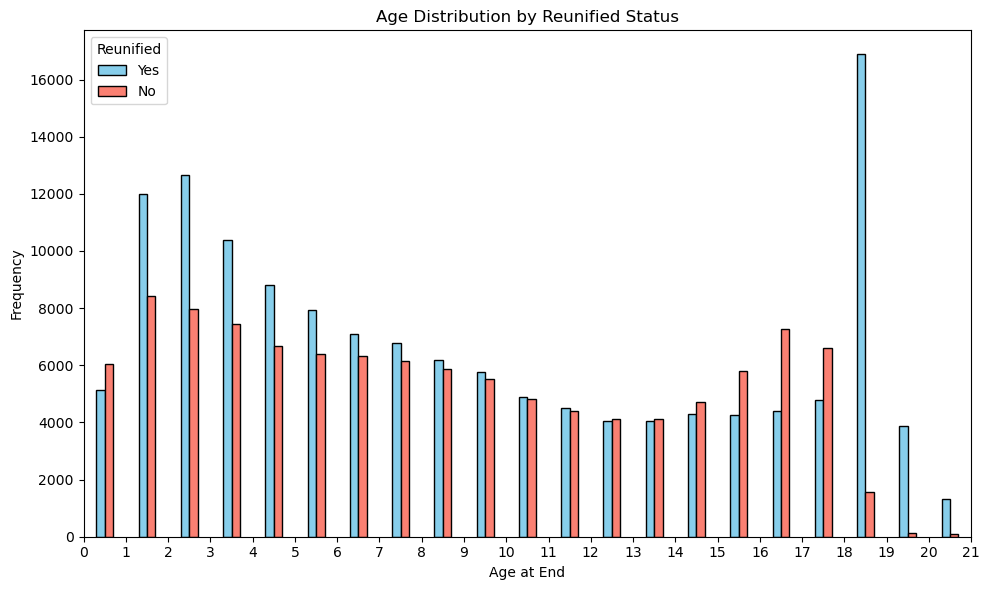

In [22]:
# Filter the DataFrame for each category in 'reunified'
group1 = records_df[records_df['reunified'] == records_df['reunified'].unique()[0]]['AGEATEND']
group2 = records_df[records_df['reunified'] == records_df['reunified'].unique()[1]]['AGEATEND']

plt.figure(figsize=(10, 6))

# Set the positions of the bars
bins = np.histogram_bin_edges(records_df['AGEATEND'], bins=21)
width = (bins[1] - bins[0]) * 0.4

plt.hist([group1, group2], bins=bins, label=[str(records_df['reunified'].unique()[0]), str(records_df['reunified'].unique()[1])], 
         color=['skyblue', 'salmon'], edgecolor='black',  rwidth=width, align='mid', histtype='bar')

plt.legend(title='Reunified', labels=['Yes', 'No'], loc='upper left')
plt.xlabel('Age at End')
plt.ylabel('Frequency')
plt.title('Age Distribution by Reunified Status')

plt.xticks(bins.round(2))
plt.xlim([bins.min(), bins.max()])  
plt.tight_layout()
plt.show()


Text(0, 0.5, '% Reunified')

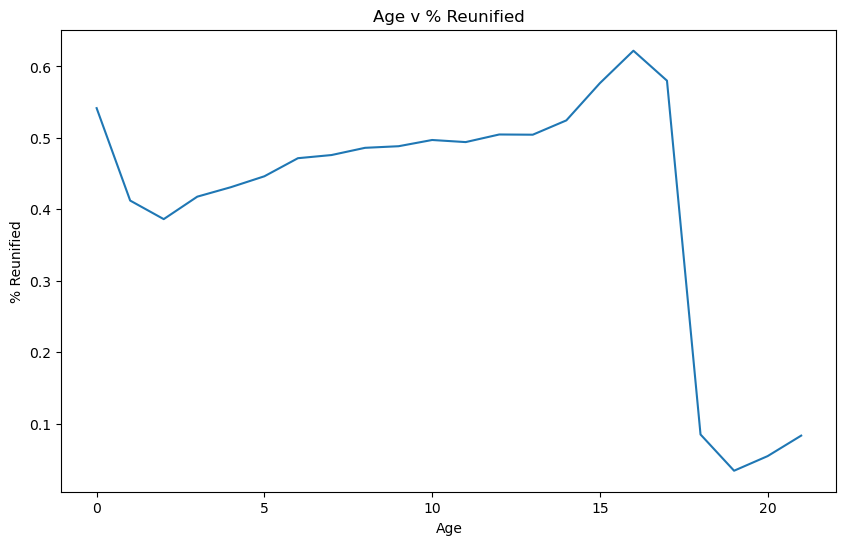

In [23]:
# plot age v % that reunified
plt.figure(figsize=(10, 6))
age_reunified = records_df.groupby('AGEATEND')['reunified'].mean()
age_reunified.plot()
plt.title('Age v % Reunified')
plt.xlabel('Age')
plt.ylabel('% Reunified')

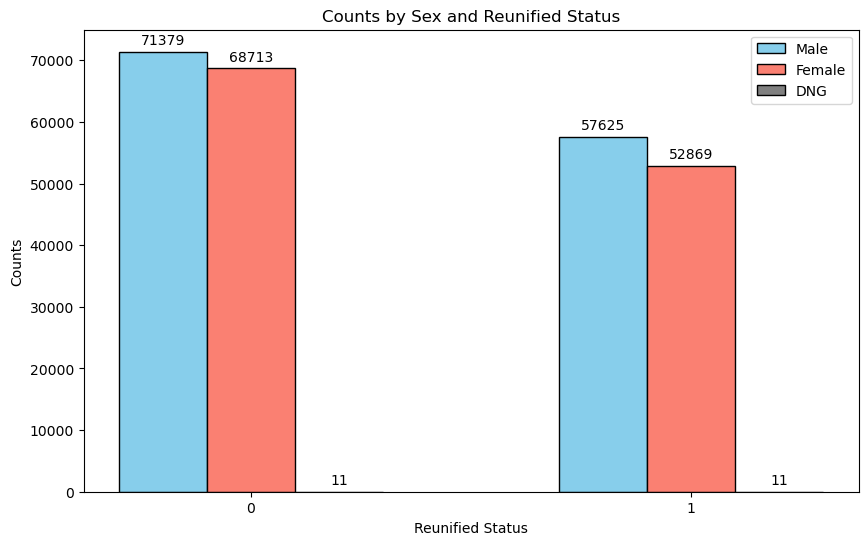

In [24]:
count_matrix = records_df.groupby(['reunified', 'Sex']).size().unstack()
fig, ax = plt.subplots(figsize=(10, 6))
ind = np.arange(len(count_matrix))
width = 0.2 # the width of the bars

# Plotting the bars
bars1 = ax.bar(ind - width, count_matrix['Male'], width, label='Male', color='skyblue', edgecolor='black')
bars2 = ax.bar(ind, count_matrix['Female'], width, label='Female', color='salmon', edgecolor='black')
bars3 = ax.bar(ind + width, count_matrix['DNG'], width, label='DNG', color='grey', edgecolor='black')

ax.set_xlabel('Reunified Status')
ax.set_ylabel('Counts')
ax.set_title('Counts by Sex and Reunified Status')
ax.set_xticks([0, 1], ['No', 'Yes'])
ax.set_xticklabels(count_matrix.index)
ax.legend()

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)
ax.bar_label(bars3, padding=3)

plt.show()


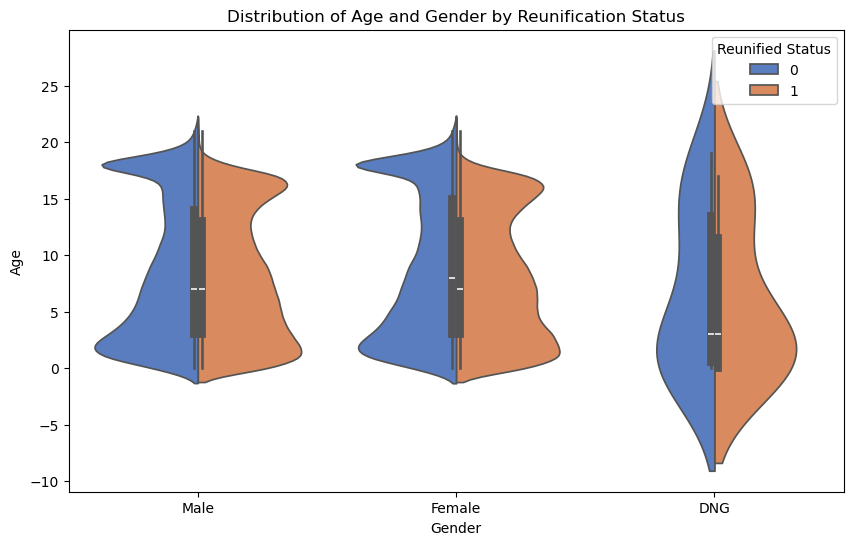

In [25]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Sex", y="AGEATEND", hue="reunified", data=records_df, palette="muted", split=True)

plt.title('Distribution of Age and Gender by Reunification Status')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.legend(title='Reunified Status')

plt.show()

# Creating Train-Validation-Test Datasets
Split the data into three sections: training at 60%, validation at 20%, and testing at 20%

In [26]:
# Shuffle the data randomly to avoid any biases
records_df = records_df.sample(frac = 1, random_state=42)

# Drop columns that are indicators or not useful
data_df = records_df.drop(['RECNUMBR', 'caseGoal', 'dischargeReason', 'FIPSCode'], axis=1)
data_oh_df = pd.get_dummies(data_df, columns=['State', 'Sex', 'removalManner', 'currentPlacementSetting', 'caretakerFamilyStructure', 'fosterFamilyStructure',  'raceEthnicity', 'diagnosedDisability', 'AgeAdopt', 'everAdopted', 'OutOfStatePlacement']) # 'FIPSCode',

X = data_oh_df.drop('reunified', axis=1)  # Features
y = data_oh_df['reunified']  # Target variable

In [27]:
# Scale X but keep the feature names
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X = pd.DataFrame(X)

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Val Set Shape: {X_val.shape}")
print(f"Test Set Shape: {X_test.shape}")

Training Set Shape: (150364, 147)
Val Set Shape: (50122, 147)
Test Set Shape: (50122, 147)


# Baseline Model

In [29]:
# baseline from test data - if we just guess the majority class
print(f"Reunified: {y_train[y_train == 1].shape[0]}")
print(f"Not Reunified: {y_train[y_train == 0].shape[0]}")

baseline = y_train.value_counts()[0] / y_train.value_counts().sum()
print(f"\nBaseline (% Reunified): {round((y_train[y_train == 1].shape[0] / y_train.shape[0])*100, 2)}%")

Reunified: 66216
Not Reunified: 84148

Baseline (% Reunified): 44.04%


## Log Loss

In [30]:
# Calculate the baseline loss for the training dataset

def log_loss(Y_true, Y_pred):
  """Returns the binary log loss for a list of labels and predictions.
  
  Args:
    Y_true: A list of (true) labels (0 or 1)
    Y_pred: A list of corresponding predicted probabilities

  Returns:
    Binary log loss
  """
  loss = -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))
  return loss

# Use the log_loss function to evaluate our baseline on the train, validation, and test dataset using the average of reunified as our predicted probability.

train_loss = log_loss(y_train, baseline)
val_loss = log_loss(y_val, baseline)
test_loss = log_loss(y_test, baseline)

print("Log Loss for Baseline on Training Dataset:", train_loss)
print("Log Loss for Baseline on Validation Dataset:", val_loss)
print("Log Loss for Baseline on Test Dataset:", test_loss)

Log Loss for Baseline on Training Dataset: 0.7145996837899794
Log Loss for Baseline on Validation Dataset: 0.7146297761308142
Log Loss for Baseline on Test Dataset: 0.7138790910155529


# Random Forest

In [31]:
# Initialize the model
rf_init = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_init.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Predictions
y_pred = rf_init.predict(X_train)

# Accuracy
print('Training Accuracy : ', 
      metrics.accuracy_score(y_train,
                             rf_init.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf_init.predict(X_val))*100)

# Classification report
print('Classification Report, Validation:\n', classification_report(y_val, rf_init.predict(X_val)))

Training Accuracy :  99.99800484158442
Validation Accuracy :  90.02234547703604
Classification Report, Validation:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     28056
           1       0.88      0.90      0.89     22066

    accuracy                           0.90     50122
   macro avg       0.90      0.90      0.90     50122
weighted avg       0.90      0.90      0.90     50122



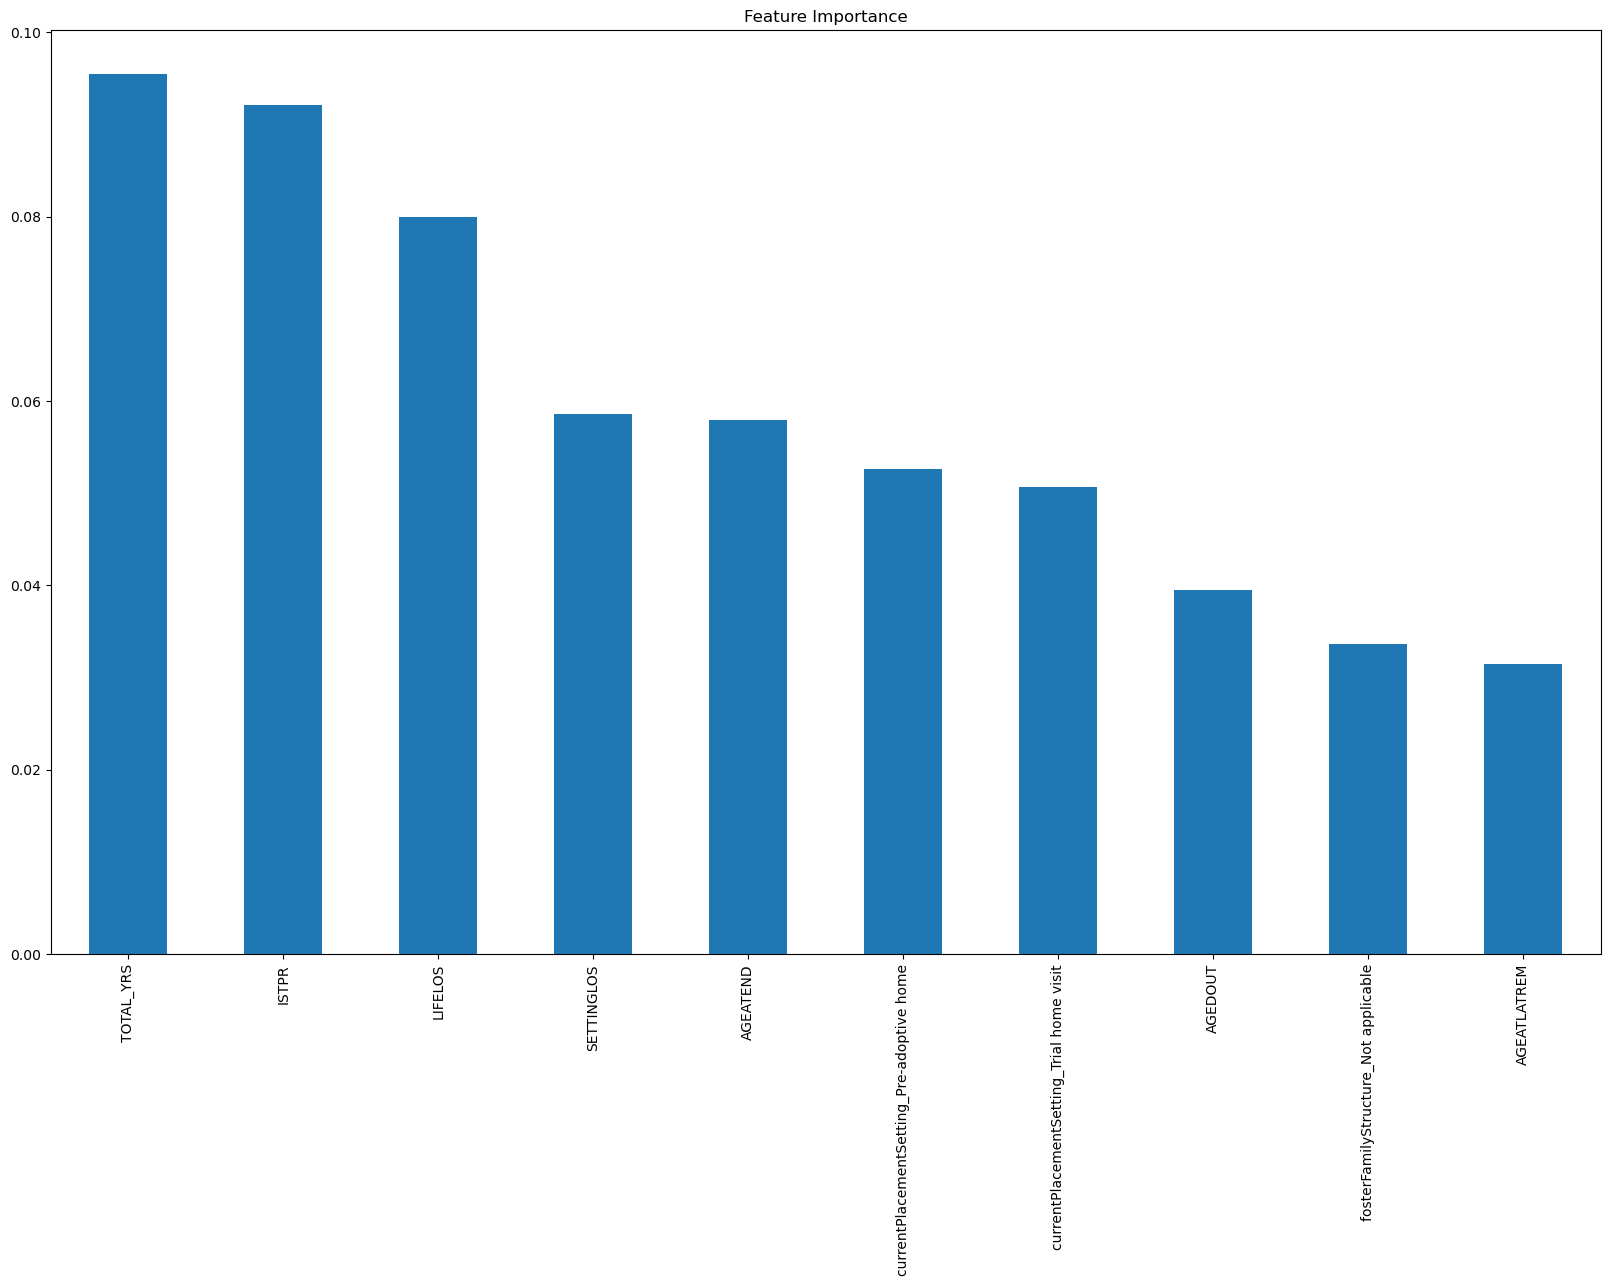

In [33]:
feature_importances = pd.Series(rf_init.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:10].plot(kind='bar', figsize=(20, 12))
plt.title('Feature Importance')
plt.show()

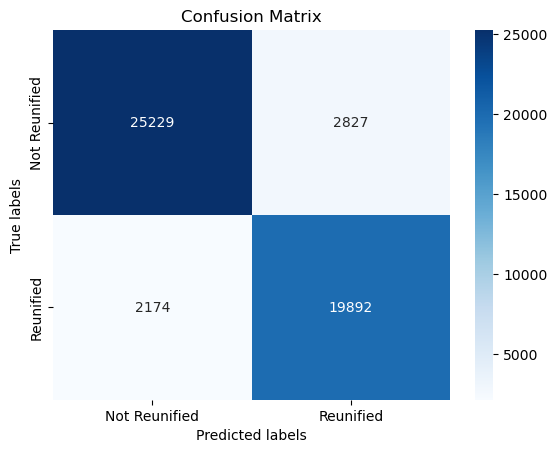

In [34]:
y_pred = rf_init.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy for 1 depth in the training data set is 68.89880556516187
Accuracy for 1 depth in the validation data set is 68.8699573041778
Difference in accuracy for depth 1 in the datasets is 0.028848260984060126
Accuracy for 6 depth in the training data set is 82.72126306828763
Accuracy for 6 depth in the validation data set is 82.59845975819002
Difference in accuracy for depth 6 in the datasets is 0.12280331009760781
Accuracy for 11 depth in the training data set is 86.37439812721131
Accuracy for 11 depth in the validation data set is 85.85052471968397
Difference in accuracy for depth 11 in the datasets is 0.523873407527331
Accuracy for 16 depth in the training data set is 89.31925194860472
Accuracy for 16 depth in the validation data set is 87.35884441961613
Difference in accuracy for depth 16 in the datasets is 1.9604075289885836
Accuracy for 21 depth in the training data set is 92.70370567423053
Accuracy for 21 depth in the validation data set is 88.26662942420495
Difference in accur

Text(0.5, 0, 'Tree depth')

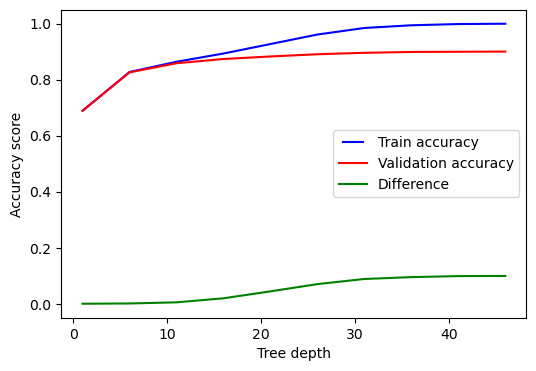

In [35]:
max_depths = np.arange(1, 50, 5)

train_results = []
val_results = []

for i in max_depths:
    dt = RandomForestClassifier(max_depth=i)
    dt.fit(X_train, y_train)    

    # Calculate and display accuracy
    accuracy_train = metrics.accuracy_score(y_train, dt.predict(X_train))
    #append results of accuracy
    print('Accuracy for', i, 'depth in the training data set is', accuracy_train*100)
    train_results.append(accuracy_train)
    
    #now again for test data
    accuracy_val = metrics.accuracy_score(y_val, dt.predict(X_val))
    #append results of accuracy
    print('Accuracy for', i, 'depth in the validation data set is', accuracy_val*100)
    val_results.append(accuracy_val)

    print('Difference in accuracy for depth', i, 'in the datasets is', (accuracy_train - accuracy_val)*100)
    
plt.figure(figsize=(6, 4))
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, val_results, 'r', label= 'Validation accuracy')
line3, = plt.plot(max_depths, np.array(train_results) - np.array(val_results), 'g', label='Difference')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')

Accuracy for 1 estimators in the training data set is 85.89755526588812
Accuracy for 1 estimators in the validation data set is 82.87179282550576
Difference in accuracy for estimators 1 in the datasets is 3.0257624403823513
Accuracy for 4 estimators in the training data set is 90.7584262190418
Accuracy for 4 estimators in the validation data set is 86.10191133633933
Difference in accuracy for estimators 4 in the datasets is 4.6565148827024565
Accuracy for 7 estimators in the training data set is 91.9102976776356
Accuracy for 7 estimators in the validation data set is 87.34487849646861
Difference in accuracy for estimators 7 in the datasets is 4.565419181166986
Accuracy for 10 estimators in the training data set is 91.87371977335
Accuracy for 10 estimators in the validation data set is 87.34687362834683
Difference in accuracy for estimators 10 in the datasets is 4.526846145003171
Accuracy for 13 estimators in the training data set is 92.4323641297119
Accuracy for 13 estimators in the va

Text(0.5, 0, 'Estimators')

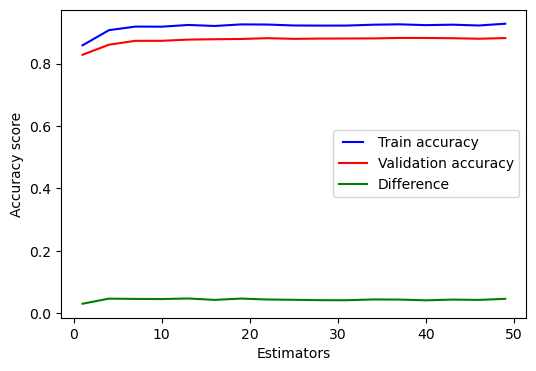

In [36]:
n_estimators = np.arange(1, 50, 3)

train_results = []
val_results = []

for i in n_estimators:
    dt = RandomForestClassifier(max_depth=21, n_estimators=i)
    dt.fit(X_train, y_train)    

    # Calculate and display accuracy
    accuracy_train = metrics.accuracy_score(y_train, dt.predict(X_train))
    #append results of accuracy
    print('Accuracy for', i, 'estimators in the training data set is', accuracy_train*100)
    train_results.append(accuracy_train)
    
    #now again for test data
    accuracy_val = metrics.accuracy_score(y_val, dt.predict(X_val))
    #append results of accuracy
    print('Accuracy for', i, 'estimators in the validation data set is', accuracy_val*100)
    val_results.append(accuracy_val)

    print('Difference in accuracy for estimators', i, 'in the datasets is', (accuracy_train - accuracy_val)*100)

plt.figure(figsize=(6, 4))
line1, = plt.plot(n_estimators, train_results, 'b', label='Train accuracy')
line2, = plt.plot(n_estimators, val_results, 'r', label= 'Validation accuracy')
line3, = plt.plot(n_estimators, np.array(train_results) - np.array(val_results), 'g', label='Difference')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Estimators')

## Update Model based on new info

In [37]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=34, max_depth=21, random_state=42)

# Train the model
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=21, n_estimators=34, random_state=42)

In [38]:
# Predictions
y_pred = rf.predict(X_train)

# Accuracy
print('Training Accuracy : ', 
      metrics.accuracy_score(y_train,
                             rf.predict(X_train))*100)
print('Validation Accuracy : ', 
      metrics.accuracy_score(y_val, 
                             rf.predict(X_val))*100)

# Classification report
print('Classification Report, Validation:\n', classification_report(y_val, rf.predict(X_val)))

Training Accuracy :  92.22420260168659
Validation Accuracy :  88.17485335780695
Classification Report, Validation:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     28056
           1       0.84      0.91      0.87     22066

    accuracy                           0.88     50122
   macro avg       0.88      0.88      0.88     50122
weighted avg       0.89      0.88      0.88     50122



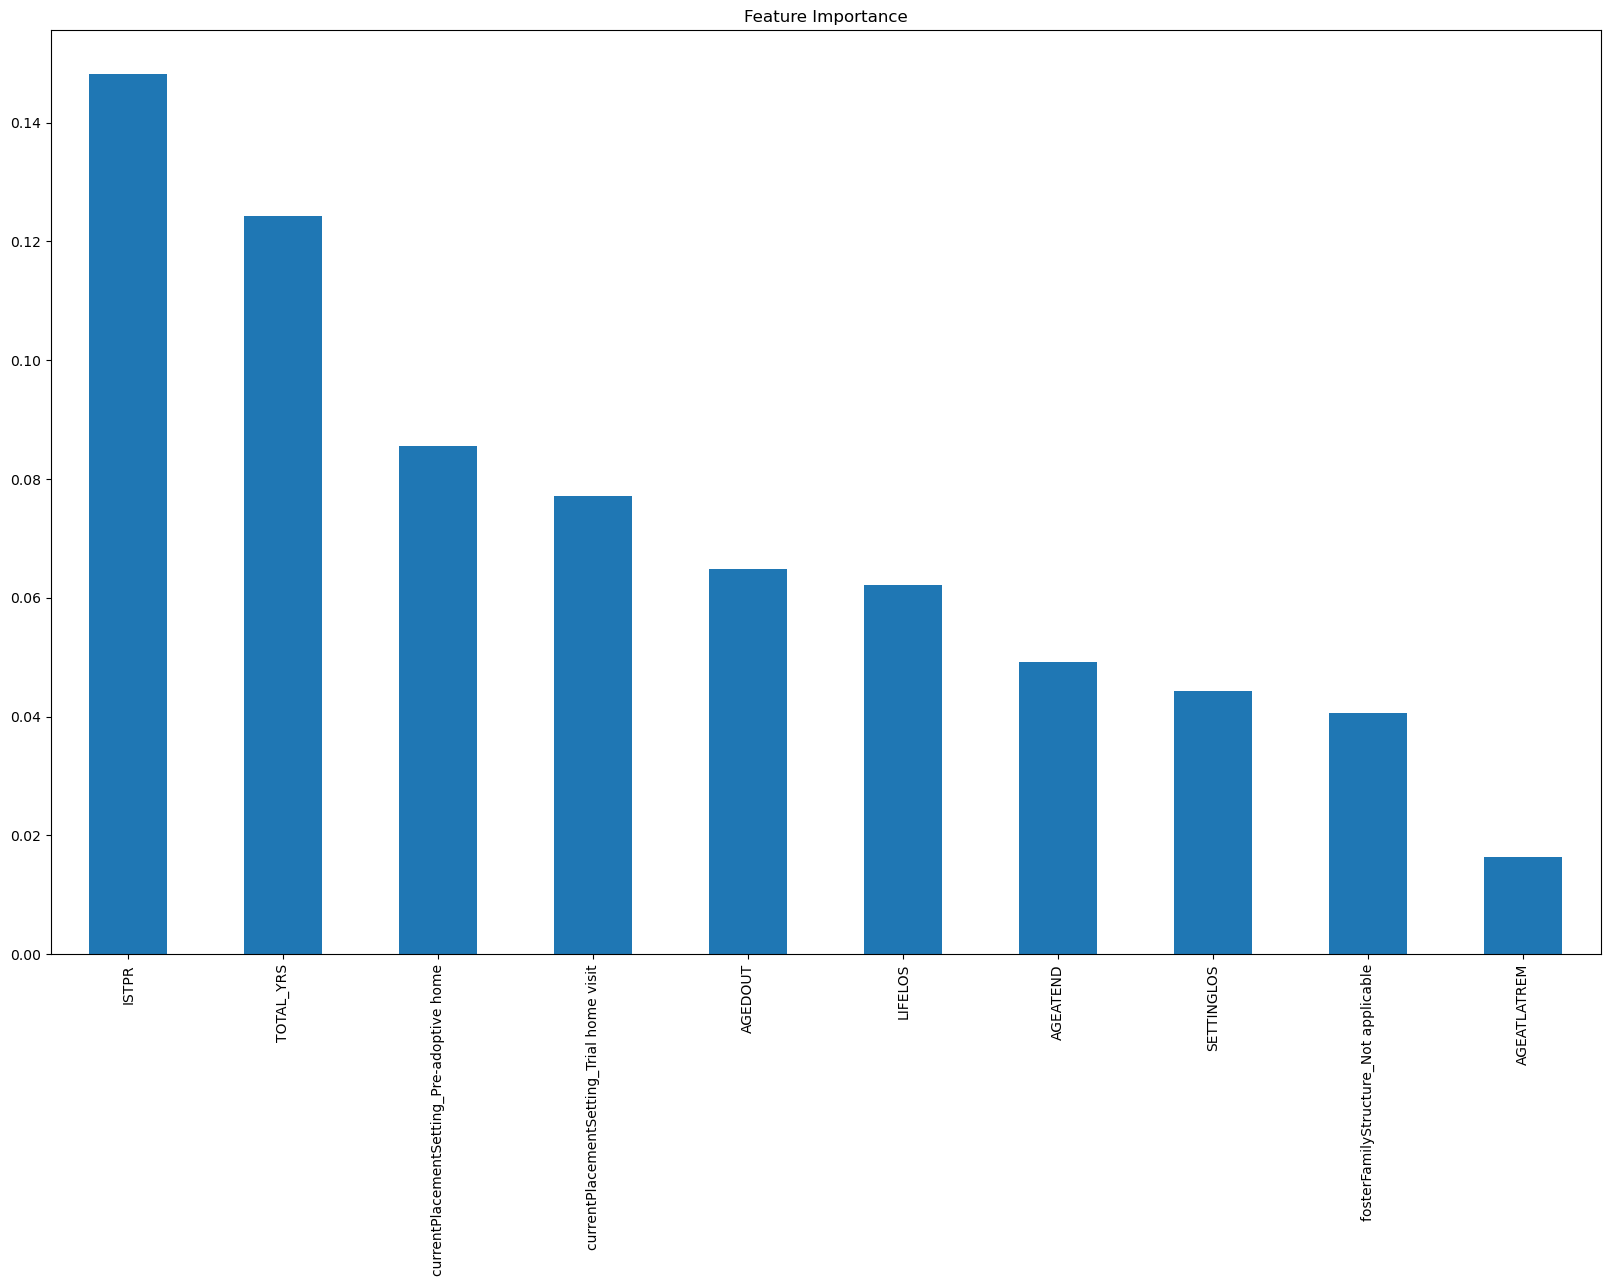

In [39]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances[:10].plot(kind='bar', figsize=(20, 12))
plt.title('Feature Importance')
plt.show()

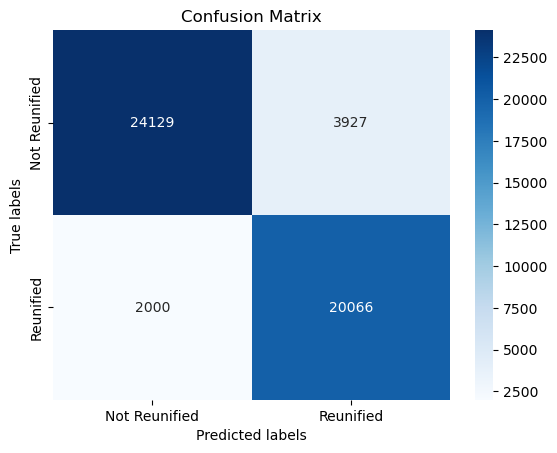

In [40]:
y_pred = rf.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# XG Boost Model

In [41]:
# Convert the datasets to DMatrix data structure (optional step for improved performance)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model training parameters
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'  # You can change this to 'auc' or other relevant metrics
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [42]:
# Making predictions
y_pred_proba = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred_proba]  # Convert probabilities to binary output

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8891105702086908
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     27899
           1       0.86      0.90      0.88     22223

    accuracy                           0.89     50122
   macro avg       0.89      0.89      0.89     50122
weighted avg       0.89      0.89      0.89     50122



# Neural Network Model

In [43]:
# Take the same split of data but witout the dummy variables
X_nd = data_df.drop('reunified', axis=1)  # Features
y_nd = data_df['reunified']  # Target variable

X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(X_nd, y_nd, test_size=0.2, random_state=42)

X_train_nd, X_val_nd, y_train_nd, y_val_nd = train_test_split(X_train_nd, y_train_nd, test_size=0.25, random_state=42)

In [44]:
def build_model():
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Numberical Inputs
    age = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Age')
    total_yrs = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='TOTAL_YRS')
    
    # Binned Numerical Inputs
    total_rem = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='TOTALREM')
    total_rem_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    total_rem_binned = tf.keras.layers.Discretization(bin_boundaries=total_rem_bins)(total_rem)
    total_rem_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(total_rem_bins)+1),
        output_mode='one_hot')(total_rem_binned)
    
    num_place = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NUMPLEP')
    num_place_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    num_place_binned = tf.keras.layers.Discretization(bin_boundaries=num_place_bins)(num_place)
    num_place_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(num_place_bins)+1),
        output_mode='one_hot')(num_place_binned)
    
    fcmntPay = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='FCMntPay')
    fcmntPay_bins = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    fcmntPay_binned = tf.keras.layers.Discretization(bin_boundaries=fcmntPay_bins)(fcmntPay)
    fcmntPay_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(fcmntPay_bins)+1),
        output_mode='one_hot')(fcmntPay_binned)
    
    settingLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SettingLOS')
    settingLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    settingLOS_binned = tf.keras.layers.Discretization(bin_boundaries=settingLOS_bins)(settingLOS)
    settingLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(settingLOS_bins)+1),
        output_mode='one_hot')(settingLOS_binned)
    
    previousLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PreviousLOS')
    previousLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    previousLOS_binned = tf.keras.layers.Discretization(bin_boundaries=previousLOS_bins)(previousLOS)
    previousLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(previousLOS_bins)+1),
        output_mode='one_hot')(previousLOS_binned)
    
    lifeLOS = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='LifeLOS')
    lifeLOS_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    lifeLOS_binned = tf.keras.layers.Discretization(bin_boundaries=lifeLOS_bins)(lifeLOS)
    lifeLOS_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(lifeLOS_bins)+1),
        output_mode='one_hot')(lifeLOS_binned)
    
    ageAtLatRem = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AgeAtLatRem')
    ageAtLatRem_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    ageAtLatRem_binned = tf.keras.layers.Discretization(bin_boundaries=ageAtLatRem_bins)(ageAtLatRem)
    ageAtLatRem_id = tf.keras.layers.IntegerLookup(
        vocabulary=np.arange(0, len(ageAtLatRem_bins)+1),
        output_mode='one_hot')(ageAtLatRem_binned)
    
    # Categorical Inputs
    sex = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sex')
    sex_id = tf.keras.layers.StringLookup(
        vocabulary=['Male', 'Female', 'DNG'], output_mode='one_hot')(sex)
    
    state = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='State')
    state_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['State'].unique(), output_mode='one_hot')(state)
    
    removal_manner = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='removalManner')
    removal_manner_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['removalManner'].unique(), output_mode='one_hot')(removal_manner)
    
    current_placement_setting = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='currentPlacementSetting')
    current_placement_setting_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['currentPlacementSetting'].unique(), output_mode='one_hot')(current_placement_setting)
    
    out_of_state_placement = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='OutOfStatePlacement')
    out_of_state_placement_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['OutOfStatePlacement'].unique(), output_mode='one_hot')(out_of_state_placement)
    
    caretaker_family_structure = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='caretakerFamilyStructure')
    caretaker_family_structure_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['caretakerFamilyStructure'].unique(), output_mode='one_hot')(caretaker_family_structure)
    
    foster_family_structure = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='fosterFamilyStructure')
    foster_family_structure_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['fosterFamilyStructure'].unique(), output_mode='one_hot')(foster_family_structure)
    
    ever_adopted = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='everAdopted')
    ever_adopted_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['everAdopted'].unique(), output_mode='one_hot')(ever_adopted)
    
    diagnosed_disability = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='diagnosedDisability')
    diagnosed_disability_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['diagnosedDisability'].unique(), output_mode='one_hot')(diagnosed_disability)
    
    raceEthnicity = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='raceEthnicity')
    raceEthnicity_id = tf.keras.layers.StringLookup(
        vocabulary=data_df['raceEthnicity'].unique(), output_mode='one_hot')(raceEthnicity)
    
    # Binary Inputs
    mr = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='MR')
    vishear = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='VISHEAR')
    phydis = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PHYDIS')
    emotdist = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='EMOTDIST')
    othermed = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='OTHERMED')
    phyabuse = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PHYABUSE')
    sexabuse = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SEXABUSE')
    neglect = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NEGLECT')
    aaparent = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AAPARENT')
    daparent = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DAPARENT')
    aachild = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='AACHILD')
    dachild = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='DACHILD')
    childis = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='CHILDIS')
    chbehprb = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='CHBEHPRB')
    prtsdied = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PRTSDIED')
    prtsjail = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='PRTSJAIL')
    nocope = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NOCOPE')
    abandmnt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='ABANDMNT')
    relinquish = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='RELINQSH')
    housing = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='HOUSING')
    ivefc = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVEFC')
    iveaa = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVEAA')
    ivaafdc = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVAAFDC')
    ivdchsup = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IVDCHSUP')
    xixmedcd = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='XIXMEDCD')
    ssiother = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='SSIOTHER')
    noa = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='NOA')
    istpr = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IsTPR')
    served = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Served')

    
    features = tf.keras.layers.Concatenate()([sex_id, 
                                              mr, vishear, phydis, othermed, phyabuse, sexabuse, neglect,  emotdist, 
                                              aaparent, daparent, aachild, dachild, childis, chbehprb, prtsdied, prtsjail, nocope, abandmnt, relinquish, housing, 
                                              ivefc, iveaa, ivaafdc, ivdchsup, xixmedcd, ssiother, noa,
                                              istpr, served, state_id, removal_manner_id, current_placement_setting_id, out_of_state_placement_id, caretaker_family_structure_id, foster_family_structure_id, ever_adopted_id, diagnosed_disability_id, raceEthnicity_id,
                                              # numerical columns
                                              age, total_yrs, # total_rem, num_place, fcmntPay, settingLOS, previousLOS, lifeLOS, ageAtLatRem
                                              # age_id, 
                                              total_rem_id, num_place_id,fcmntPay_id, settingLOS_id, previousLOS_id, lifeLOS_id, ageAtLatRem_id
                                              ])

    normalized_features = tf.keras.layers.BatchNormalization()(features)
    
    dense = tf.keras.layers.Dense(units=64, activation='relu', name='hidden1')(normalized_features)
    dense = tf.keras.layers.Dropout(0.3)(dense)
    
    dense = tf.keras.layers.Dense(units=32, activation='relu', name='hidden2')(dense)
    dense = tf.keras.layers.Dropout(0.3)(dense)

    reunified = tf.keras.layers.Dense(units=1, activation='sigmoid', name='reunified')(dense)

    model = tf.keras.Model(inputs=[sex, 
                                   mr, vishear, phydis,  othermed, phyabuse, sexabuse, neglect, emotdist,
                                   aaparent, daparent, aachild, dachild, childis, chbehprb, prtsdied, prtsjail, nocope, abandmnt, relinquish, housing,
                                   ivefc, iveaa, ivaafdc, ivdchsup, xixmedcd, ssiother, noa,
                                   istpr, served, state, removal_manner, current_placement_setting, out_of_state_placement, caretaker_family_structure, foster_family_structure, ever_adopted, diagnosed_disability, raceEthnicity,
                                   # numerical columns
                                    age, total_yrs, total_rem, num_place, fcmntPay, settingLOS, previousLOS, lifeLOS, ageAtLatRem
                                   ], 
                           outputs=reunified, 
                           name='Foster')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [45]:
model_init = build_model()

inputs_train = {
        'Age': X_train_nd['AGEATEND'],
        'TOTAL_YRS': X_train_nd['TOTAL_YRS'], 
        'Sex': X_train_nd['Sex'],
        'MR': X_train_nd['MR'],
        'TOTALREM': X_train_nd['TOTALREM'],
        'NUMPLEP': X_train_nd['NUMPLEP'],
        'VISHEAR': X_train_nd['VISHEAR'],
        'PHYDIS': X_train_nd['PHYDIS'],
        'EMOTDIST': X_train_nd['EMOTDIST'],
        'OTHERMED': X_train_nd['OTHERMED'],
        'PHYABUSE': X_train_nd['PHYABUSE'],
        'SEXABUSE': X_train_nd['SEXABUSE'],
        'NEGLECT': X_train_nd['NEGLECT'],
        'AAPARENT': X_train_nd['AAPARENT'],
        'DAPARENT': X_train_nd['DAPARENT'],
        'AACHILD': X_train_nd['AACHILD'],
        'DACHILD': X_train_nd['DACHILD'],
        'CHILDIS': X_train_nd['CHILDIS'],
        'CHBEHPRB': X_train_nd['CHBEHPRB'],
        'PRTSDIED': X_train_nd['PRTSDIED'],
        'PRTSJAIL': X_train_nd['PRTSJAIL'],
        'NOCOPE': X_train_nd['NOCOPE'],
        'ABANDMNT': X_train_nd['ABANDMNT'],
        'RELINQSH': X_train_nd['RELINQSH'],
        'HOUSING': X_train_nd['HOUSING'],
        'IVEFC': X_train_nd['IVEFC'],
        'IVEAA': X_train_nd['IVEAA'],
        'IVAAFDC': X_train_nd['IVAAFDC'],
        'IVDCHSUP': X_train_nd['IVDCHSUP'],
        'XIXMEDCD': X_train_nd['XIXMEDCD'],
        'SSIOTHER': X_train_nd['SSIOTHER'],
        'NOA': X_train_nd['NOA'],
        'FCMntPay': X_train_nd['FCMNTPAY'],
        'SettingLOS': X_train_nd['SETTINGLOS'],
        'PreviousLOS': X_train_nd['PREVIOUSLOS'],
        'LifeLOS': X_train_nd['LIFELOS'],
        'AgeAtLatRem': X_train_nd['AGEATLATREM'],
        'IsTPR': X_train_nd['ISTPR'],
        'Served': X_train_nd['SERVED'],
        'State': X_train_nd['State'],
        'removalManner': X_train_nd['removalManner'],
        'currentPlacementSetting': X_train_nd['currentPlacementSetting'],
        'caretakerFamilyStructure': X_train_nd['caretakerFamilyStructure'],
        'fosterFamilyStructure': X_train_nd['fosterFamilyStructure'],
        'OutOfStatePlacement': X_train_nd['OutOfStatePlacement'],
        'everAdopted': X_train_nd['everAdopted'],
        'diagnosedDisability': X_train_nd['diagnosedDisability'],
        'raceEthnicity': X_train_nd['raceEthnicity']
        }

inputs_val = {
        'Age': X_val_nd['AGEATEND'],
        'TOTAL_YRS': X_val_nd['TOTAL_YRS'], 
        'Sex': X_val_nd['Sex'],
        'MR': X_val_nd['MR'],
        'TOTALREM': X_val_nd['TOTALREM'],
        'NUMPLEP': X_val_nd['NUMPLEP'],
        'VISHEAR': X_val_nd['VISHEAR'],
        'PHYDIS': X_val_nd['PHYDIS'],
        'EMOTDIST': X_val_nd['EMOTDIST'],
        'OTHERMED': X_val_nd['OTHERMED'],
        'PHYABUSE': X_val_nd['PHYABUSE'],
        'SEXABUSE': X_val_nd['SEXABUSE'],
        'NEGLECT': X_val_nd['NEGLECT'],
        'AAPARENT': X_val_nd['AAPARENT'],
        'DAPARENT': X_val_nd['DAPARENT'],
        'AACHILD': X_val_nd['AACHILD'],
        'DACHILD': X_val_nd['DACHILD'],
        'CHILDIS': X_val_nd['CHILDIS'],
        'CHBEHPRB': X_val_nd['CHBEHPRB'],
        'PRTSDIED': X_val_nd['PRTSDIED'],
        'PRTSJAIL': X_val_nd['PRTSJAIL'],
        'NOCOPE': X_val_nd['NOCOPE'],
        'ABANDMNT': X_val_nd['ABANDMNT'],
        'RELINQSH': X_val_nd['RELINQSH'],
        'HOUSING': X_val_nd['HOUSING'],
        'IVEFC': X_val_nd['IVEFC'],
        'IVEAA': X_val_nd['IVEAA'],
        'IVAAFDC': X_val_nd['IVAAFDC'],
        'IVDCHSUP': X_val_nd['IVDCHSUP'],
        'XIXMEDCD': X_val_nd['XIXMEDCD'],
        'SSIOTHER': X_val_nd['SSIOTHER'],
        'NOA': X_val_nd['NOA'],
        'FCMntPay': X_val_nd['FCMNTPAY'],
        'SettingLOS': X_val_nd['SETTINGLOS'],
        'PreviousLOS': X_val_nd['PREVIOUSLOS'],
        'LifeLOS': X_val_nd['LIFELOS'],
        'AgeAtLatRem': X_val_nd['AGEATLATREM'],
        'IsTPR': X_val_nd['ISTPR'],
        'Served': X_val_nd['SERVED'],
        'State': X_val_nd['State'],
        'removalManner': X_val_nd['removalManner'],
        'currentPlacementSetting': X_val_nd['currentPlacementSetting'],
        'caretakerFamilyStructure': X_val_nd['caretakerFamilyStructure'],
        'fosterFamilyStructure': X_val_nd['fosterFamilyStructure'],
        'OutOfStatePlacement': X_val_nd['OutOfStatePlacement'],
        'everAdopted': X_val_nd['everAdopted'],
        'diagnosedDisability': X_val_nd['diagnosedDisability'],
        'raceEthnicity': X_val_nd['raceEthnicity']
        }

history = model_init.fit(
    x = inputs_train,
    y = y_train_nd,
    validation_data=(
        inputs_val,
        y_val_nd),
    epochs=10,
    batch_size=32
)


Epoch 1/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 87s 18ms/step - accuracy: 0.7888 - loss: 0.4217 - val_accuracy: 0.8562 - val_loss: 0.3247
Epoch 2/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.8505 - loss: 0.3319 - val_accuracy: 0.8617 - val_loss: 0.3168
Epoch 3/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.8567 - loss: 0.3187 - val_accuracy: 0.8637 - val_loss: 0.3151
Epoch 4/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 87s 19ms/step - accuracy: 0.8615 - loss: 0.3118 - val_accuracy: 0.8654 - val_loss: 0.3197
Epoch 5/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 73s 16ms/step - accuracy: 0.8643 - loss: 0.3069 - val_accuracy: 0.8653 - val_loss: 0.3171
Epoch 6/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - accuracy: 0.8665 - loss: 0.3016 - val_accuracy: 0.8659 - val_loss: 0.3200
Epoch 7/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.8679 - loss: 0.2980 - val_accuracy: 0.8654 - val_loss: 0.3188
Epoch 8/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 79s 17ms/step - accuracy: 0.8696 -

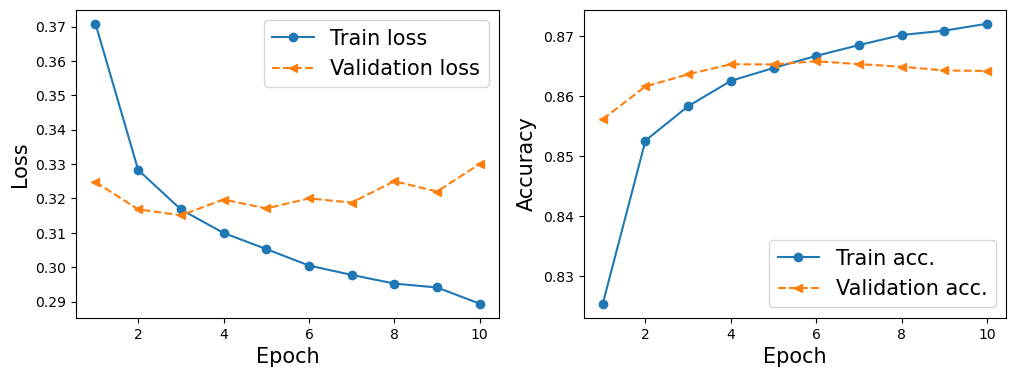

In [46]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [47]:
# Select 4 epochs as most ideal hyperparameter

model = build_model()

history = model.fit(
    x = inputs_train,
    y = y_train_nd,
    validation_data=(
        inputs_val,
        y_val_nd),
    epochs=4,
    batch_size=32
)

Epoch 1/4
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - accuracy: 0.7972 - loss: 0.4098 - val_accuracy: 0.8541 - val_loss: 0.3267
Epoch 2/4
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 75s 16ms/step - accuracy: 0.8488 - loss: 0.3317 - val_accuracy: 0.8616 - val_loss: 0.3150
Epoch 3/4
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - accuracy: 0.8574 - loss: 0.3191 - val_accuracy: 0.8622 - val_loss: 0.3133
Epoch 4/4
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 78s 17ms/step - accuracy: 0.8613 - loss: 0.3112 - val_accuracy: 0.8630 - val_loss: 0.3139


In [48]:
print("Accuracy - Age & Sex Only: 0.5622")
print("Accuracy - (Age, sex, All cols to Housing): 0.6351")
print("Accuracy - (Age, sex, All cols to Housing): 0.6624")
print("Accuracy - (Age, sex, All cols not race eth): 0.81")
print("Accuracy with binning: 0.8230")
print("Accuracy without binning: 0.7834")
print("Accuracy with binning except age: 0.8283")

print("Accuracy with new 2019-2021 dataset: 0.8864")

Accuracy - Age & Sex Only: 0.5622
Accuracy - (Age, sex, All cols to Housing): 0.6351
Accuracy - (Age, sex, All cols to Housing): 0.6624
Accuracy - (Age, sex, All cols not race eth): 0.81
Accuracy with binning: 0.8230
Accuracy without binning: 0.7834
Accuracy with binning except age: 0.8283
Accuracy with new 2019-2021 dataset: 0.8864


1567/1567 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step


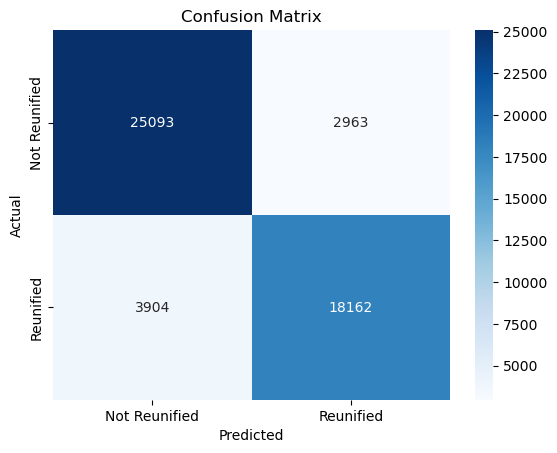

In [49]:
# Create a confusion matrix for the neural network
predictions_prob = model.predict(inputs_val)
predictions = (predictions_prob > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_val, predictions)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Reunified', 'Reunified'], yticklabels=['Not Reunified', 'Reunified'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Final Test of Models 

In [50]:
# Test the final Random Forest model
print('Test Accuracy : ', 
      metrics.accuracy_score(y_test,
                             rf.predict(X_test))*100)

# Classification report
print('Classification Report, Test:\n', classification_report(y_test, rf.predict(X_test)))

Test Accuracy :  88.37237141375044
Classification Report, Test:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     27899
           1       0.84      0.91      0.87     22223

    accuracy                           0.88     50122
   macro avg       0.88      0.89      0.88     50122
weighted avg       0.89      0.88      0.88     50122



In [52]:
# Create an input for the test var dataset
inputs_test = {
        'Age': X_test_nd['AGEATEND'],
        'TOTAL_YRS': X_test_nd['TOTAL_YRS'], 
        'Sex': X_test_nd['Sex'],
        'MR': X_test_nd['MR'],
        'TOTALREM': X_test_nd['TOTALREM'],
        'NUMPLEP': X_test_nd['NUMPLEP'],
        'VISHEAR': X_test_nd['VISHEAR'],
        'PHYDIS': X_test_nd['PHYDIS'],
        'EMOTDIST': X_test_nd['EMOTDIST'],
        'OTHERMED': X_test_nd['OTHERMED'],
        'PHYABUSE': X_test_nd['PHYABUSE'],
        'SEXABUSE': X_test_nd['SEXABUSE'],
        'NEGLECT': X_test_nd['NEGLECT'],
        'AAPARENT': X_test_nd['AAPARENT'],
        'DAPARENT': X_test_nd['DAPARENT'],
        'AACHILD': X_test_nd['AACHILD'],
        'DACHILD': X_test_nd['DACHILD'],
        'CHILDIS': X_test_nd['CHILDIS'],
        'CHBEHPRB': X_test_nd['CHBEHPRB'],
        'PRTSDIED': X_test_nd['PRTSDIED'],
        'PRTSJAIL': X_test_nd['PRTSJAIL'],
        'NOCOPE': X_test_nd['NOCOPE'],
        'ABANDMNT': X_test_nd['ABANDMNT'],
        'RELINQSH': X_test_nd['RELINQSH'],
        'HOUSING': X_test_nd['HOUSING'],
        'IVEFC': X_test_nd['IVEFC'],
        'IVEAA': X_test_nd['IVEAA'],
        'IVAAFDC': X_test_nd['IVAAFDC'],
        'IVDCHSUP': X_test_nd['IVDCHSUP'],
        'XIXMEDCD': X_test_nd['XIXMEDCD'],
        'SSIOTHER': X_test_nd['SSIOTHER'],
        'NOA': X_test_nd['NOA'],
        'FCMntPay': X_test_nd['FCMNTPAY'],
        'SettingLOS': X_test_nd['SETTINGLOS'],
        'PreviousLOS': X_test_nd['PREVIOUSLOS'],
        'LifeLOS': X_test_nd['LIFELOS'],
        'AgeAtLatRem': X_test_nd['AGEATLATREM'],
        'IsTPR': X_test_nd['ISTPR'],
        'Served': X_test_nd['SERVED'],
        'State': X_test_nd['State'],
        'removalManner': X_test_nd['removalManner'],
        'currentPlacementSetting': X_test_nd['currentPlacementSetting'],
        'caretakerFamilyStructure': X_test_nd['caretakerFamilyStructure'],
        'fosterFamilyStructure': X_test_nd['fosterFamilyStructure'],
        'OutOfStatePlacement': X_test_nd['OutOfStatePlacement'],
        'everAdopted': X_test_nd['everAdopted'],
        'diagnosedDisability': X_test_nd['diagnosedDisability'],
        'raceEthnicity': X_test_nd['raceEthnicity']
        }

In [53]:
# Evalute the neural net with the test data
test_loss, test_accuracy = model.evaluate(inputs_test, y_test_nd, verbose=0)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

Test Accuracy: 0.8615777492523193
Test Loss: 0.31856921315193176


# Bias Testing

In [54]:
# Predict for Random Forest Model
rf_y_pred = rf.predict(X_test)

# Convert predictions to a binary outcome
rf_y_pred_binary = (rf_y_pred > 0.5).astype(int)

# Ensure X_test is a DataFrame and create a new DataFrame from it
rf_test_df = pd.DataFrame(X_test).reset_index(drop=True)

# Reset the index of y_test if it's a Series to align with the DataFrame's index
# If y_test is an array, this step is not necessary
rf_test_df['Actual'] = y_test.reset_index(drop=True) if isinstance(y_test, pd.Series) else y_test

# Assign the binary predictions
# This should work as is if rf_y_pred_binary is an array, but if it's a Series, you need to reset the index
rf_test_df['Predicted'] = rf_y_pred_binary.reset_index(drop=True) if isinstance(rf_y_pred_binary, pd.Series) else rf_y_pred_binary

# Now rf_test_df should have the columns properly added


In [55]:
# Predict for NN Model
nn_y_pred = model.predict(inputs_test)
# Convert predictions to a binary outcome
nn_y_pred_binary = (nn_y_pred > 0.5).astype(int)

# Add predictions to your test dataframe
nn_test_df = pd.DataFrame(inputs_test, columns=inputs_test.keys())
nn_test_df['Actual'] = y_test_nd
nn_test_df['Predicted'] = nn_y_pred_binary

1567/1567 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step


### Sex - Random Forest

In [56]:
# Calculate accuracy for each group
rf_accuracy_female = rf_test_df[rf_test_df['Sex_Female'] == 1]['Actual'] == rf_test_df[rf_test_df['Sex_Female'] == 1]['Predicted']
rf_accuracy_male = rf_test_df[rf_test_df['Sex_Male'] == -1]['Actual'] == rf_test_df[rf_test_df['Sex_Male'] == -1]['Predicted']
rf_accuracy_dng = rf_test_df[rf_test_df['Sex_DNG'] == 1]['Actual'] == rf_test_df[rf_test_df['Sex_DNG'] == 1]['Predicted']

print(f"Accuracy for Male: {rf_accuracy_male.mean()}")
print(f"Accuracy for Female: {rf_accuracy_female.mean()}")
print(f"Accuracy for DNG: {rf_accuracy_dng.mean()}")

Accuracy for Male: 0.8823724046653983
Accuracy for Female: 0.8823480742977703
Accuracy for DNG: 1.0


### Sex - Neural Network

In [57]:
# Calculate accuracy for each group
nn_accuracy_female = nn_test_df[nn_test_df['Sex'] == 'Female']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'Female']['Predicted']
nn_accuracy_male = nn_test_df[nn_test_df['Sex'] == 'Male']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'Male']['Predicted']
nn_accuracy_dng = nn_test_df[nn_test_df['Sex'] == 'DNG']['Actual'] == nn_test_df[nn_test_df['Sex'] == 'DNG']['Predicted']

print(f"Accuracy for Male: {nn_accuracy_male.mean()}")
print(f"Accuracy for Female: {nn_accuracy_female.mean()}")
print(f"Accuracy for DNG: {nn_accuracy_dng.mean()}")

Accuracy for Male: 0.8612781375269812
Accuracy for Female: 0.861870682166053
Accuracy for DNG: 1.0


## Plot Sex Bias

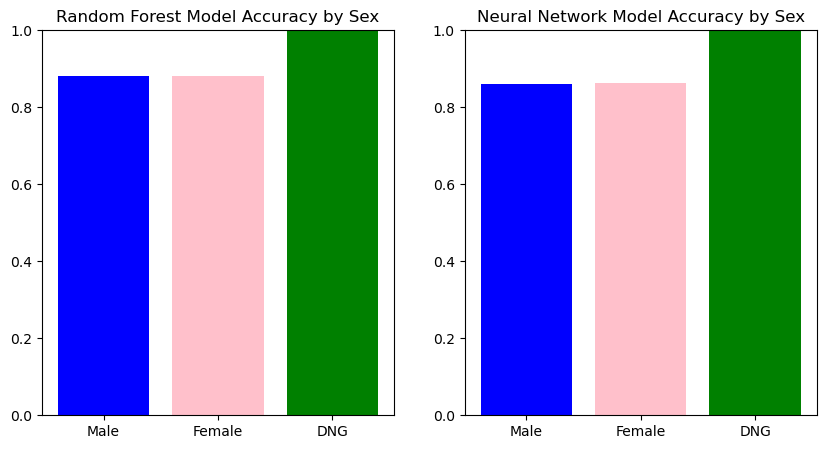

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

labels = ['Male', 'Female', 'DNG']
colors = ['blue', 'pink', 'green']

# Random Forest
rf_accuracies = [rf_accuracy_male.mean(), rf_accuracy_female.mean(), rf_accuracy_dng.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Sex')
axs[0].set_ylim(0, 1)

# Neural Net
nn_accuracies = [nn_accuracy_male.mean(), nn_accuracy_female.mean(), nn_accuracy_dng.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Sex')
axs[1].set_ylim(0, 1)

# Display the plots
plt.show()

### Race - Random Forest

In [59]:

rf_accuracy_white = rf_test_df[rf_test_df['raceEthnicity_Non-Hispanic (NH), White'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Non-Hispanic (NH), White'] == True]['Predicted']
rf_accuracy_black = rf_test_df[rf_test_df['raceEthnicity_NH, Black'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Black'] == True]['Predicted']
rf_accuracy_hispanic = rf_test_df[rf_test_df['raceEthnicity_Hispanic (Any Race)'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Hispanic (Any Race)'] == True]['Predicted']
rf_accuracy_unknown = rf_test_df[rf_test_df['raceEthnicity_Race/Ethnicity Unknown'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_Race/Ethnicity Unknown'] == True]['Predicted']
rf_accuracy_native = rf_test_df[rf_test_df['raceEthnicity_NH, Am Ind AK Native'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Am Ind AK Native'] == True]['Predicted']
rf_accuracy_more = rf_test_df[rf_test_df['raceEthnicity_NH, More than One Race'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, More than One Race'] == True]['Predicted']
rf_accuracy_asian = rf_test_df[rf_test_df['raceEthnicity_NH, Asian'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Asian'] == True]['Predicted']
rf_accuracy_pacific = rf_test_df[rf_test_df['raceEthnicity_NH, Hawaiian / Other Pac Islander'] == True]['Actual'] == rf_test_df[rf_test_df['raceEthnicity_NH, Hawaiian / Other Pac Islander'] == True]['Predicted']

print(f"Accuracy for Black: {rf_accuracy_black.mean()}")
print(f"Accuracy for White: {rf_accuracy_white.mean()}")
print(f"Accuracy for Hispanic: {rf_accuracy_hispanic.mean()}")
print(f"Accuracy for Unknown: {rf_accuracy_unknown.mean()}")
print(f"Accuracy for Native: {rf_accuracy_native.mean()}")
print(f"Accuracy for More: {rf_accuracy_more.mean()}")
print(f"Accuracy for Asian: {rf_accuracy_asian.mean()}")
print(f"Accuracy for Pacific: {rf_accuracy_pacific.mean()}")

Accuracy for Black: 0.8645823866218304
Accuracy for White: 0.8850631324438076
Accuracy for Hispanic: 0.9038878842676311
Accuracy for Unknown: 0.8947368421052632
Accuracy for Native: 0.8276199804113614
Accuracy for More: 0.8830376940133038
Accuracy for Asian: 0.9129032258064517
Accuracy for Pacific: 0.8921568627450981


### Race - Neural Network

In [60]:
nn_test_df['raceEthnicity'].value_counts()

raceEthnicity
Non-Hispanic (NH), White             22334
Hispanic (Any Race)                  11060
NH, Black                            11003
NH, More than One Race                3608
NH, Am Ind AK Native                  1021
Race/Ethnicity Unknown                 684
NH, Asian                              310
NH, Hawaiian / Other Pac Islander      102
Name: count, dtype: int64

In [61]:
# Calculate accuracy for each group
nn_accuracy_white = nn_test_df[nn_test_df['raceEthnicity'] == 'Non-Hispanic (NH), White']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Non-Hispanic (NH), White']['Predicted']
nn_accuracy_black = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Black']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Black']['Predicted']
nn_accuracy_hispanic = nn_test_df[nn_test_df['raceEthnicity'] == 'Hispanic (Any Race)']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Hispanic (Any Race)']['Predicted']
nn_accuracy_unknown = nn_test_df[nn_test_df['raceEthnicity'] == 'Race/Ethnicity Unknown']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'Race/Ethnicity Unknown']['Predicted']
nn_accuracy_native = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Am Ind AK Native']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Am Ind AK Native']['Predicted']
nn_accuracy_more = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, More than One Race']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, More than One Race']['Predicted']
nn_accuracy_asian = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Asian']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Asian']['Predicted']
nn_accuracy_pacific = nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Hawaiian / Other Pac Islander']['Actual'] == nn_test_df[nn_test_df['raceEthnicity'] == 'NH, Hawaiian / Other Pac Islander']['Predicted']


print(f"Accuracy for Black: {nn_accuracy_black.mean()}")
print(f"Accuracy for White: {nn_accuracy_white.mean()}")
print(f"Accuracy for Hispanic: {nn_accuracy_hispanic.mean()}")
print(f"Accuracy for Unknown: {nn_accuracy_unknown.mean()}")
print(f"Accuracy for Native: {nn_accuracy_native.mean()}")
print(f"Accuracy for More: {nn_accuracy_more.mean()}")
print(f"Accuracy for Asian: {nn_accuracy_asian.mean()}")
print(f"Accuracy for Pacific: {nn_accuracy_pacific.mean()}")

Accuracy for Black: 0.8373170953376352
Accuracy for White: 0.8646458314677173
Accuracy for Hispanic: 0.8803797468354431
Accuracy for Unknown: 0.8581871345029239
Accuracy for Native: 0.8178256611165524
Accuracy for More: 0.8727827050997783
Accuracy for Asian: 0.867741935483871
Accuracy for Pacific: 0.8137254901960784


## Plot Race Bias

/var/folders/nn/49kzzxpn0r91n0t4vclvggy40000gn/T/ipykernel_54869/139782139.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45)
/var/folders/nn/49kzzxpn0r91n0t4vclvggy40000gn/T/ipykernel_54869/139782139.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45)


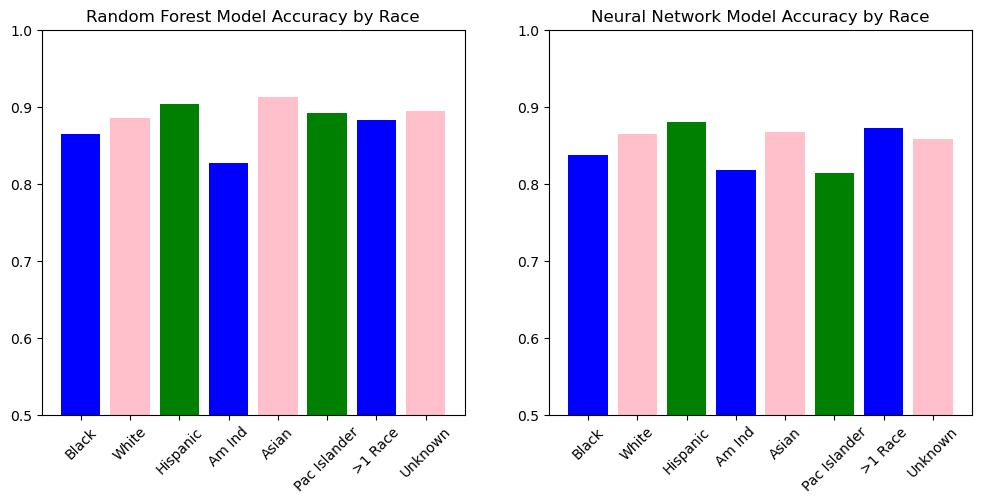

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

labels = ['Black', 'White', 'Hispanic', 'Am Ind', 'Asian', 'Pac Islander', '>1 Race', 'Unknown']
# colors = ['blue', 'pink', 'green']

# Random Forest
rf_accuracies = [rf_accuracy_black.mean(), rf_accuracy_white.mean(), rf_accuracy_hispanic.mean(), rf_accuracy_native.mean(), rf_accuracy_asian.mean(), rf_accuracy_pacific.mean(),  rf_accuracy_more.mean(), rf_accuracy_unknown.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Race')
axs[0].set_ylim(.5, 1)
axs[0].set_xticklabels(labels, rotation=45)

# Neural Net
nn_accuracies = [nn_accuracy_black.mean(), nn_accuracy_white.mean(), nn_accuracy_hispanic.mean(), nn_accuracy_native.mean(), nn_accuracy_asian.mean(), nn_accuracy_pacific.mean(), nn_accuracy_more.mean(), nn_accuracy_unknown.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Race')
axs[1].set_ylim(.5, 1)
axs[1].set_xticklabels(labels, rotation=45)

# Display the plots
plt.show()


### Dignosed Disability - Random Forest

In [63]:
rf_accuracy_yes = rf_test_df[rf_test_df['diagnosedDisability_Yes'] == 1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_Yes'] == 1]['Predicted']
rf_accuracy_no = rf_test_df[rf_test_df['diagnosedDisability_No'] == -1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_No'] == -1]['Predicted']
rf_accuracy_dng = rf_test_df[rf_test_df['diagnosedDisability_DNG'] == 1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_DNG'] == 1]['Predicted']
rf_accuracy_nyd = rf_test_df[rf_test_df['diagnosedDisability_Not yet determined'] == 1]['Actual'] == rf_test_df[rf_test_df['diagnosedDisability_Not yet determined'] == 1]['Predicted']

print(f"Accuracy for No Disability: {rf_accuracy_no.mean()}")
print(f"Accuracy for Disability: {rf_accuracy_yes.mean()}")
print(f"Accuracy for DNG: {rf_accuracy_dng.mean()}")
print(f"Accuracy for Not Yet Determined: {rf_accuracy_nyd.mean()}")

Accuracy for No Disability: 0.8917966298102458
Accuracy for Disability: 0.9165875959630811
Accuracy for DNG: 0.8718505647263249
Accuracy for Not Yet Determined: 0.8563673708920188


### Diagnosed Disability - Neural Network

In [64]:
nn_accuracy_yes = nn_test_df[nn_test_df['diagnosedDisability'] == 'Yes']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'Yes']['Predicted']
nn_accuracy_no = nn_test_df[nn_test_df['diagnosedDisability'] == 'No']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'No']['Predicted']
nn_accuracy_dng = nn_test_df[nn_test_df['diagnosedDisability'] == 'DNG']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'DNG']['Predicted']
nn_accuracy_nyd = nn_test_df[nn_test_df['diagnosedDisability'] == 'Not yet determined']['Actual'] == nn_test_df[nn_test_df['diagnosedDisability'] == 'Not yet determined']['Predicted']

print(f"Accuracy for No Disability: {nn_accuracy_no.mean()}")
print(f"Accuracy for Disability: {nn_accuracy_yes.mean()}")
print(f"Accuracy for DNG: {nn_accuracy_dng.mean()}")
print(f"Accuracy for Not Yet Determined: {nn_accuracy_nyd.mean()}")

Accuracy for No Disability: 0.8606643772738091
Accuracy for Disability: 0.8825153109635124
Accuracy for DNG: 0.8310165073848828
Accuracy for Not Yet Determined: 0.8402288732394366


## Plot Diagnosed Disability Bias

/var/folders/nn/49kzzxpn0r91n0t4vclvggy40000gn/T/ipykernel_54869/2371518434.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels, rotation=45)
/var/folders/nn/49kzzxpn0r91n0t4vclvggy40000gn/T/ipykernel_54869/2371518434.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels, rotation=45)


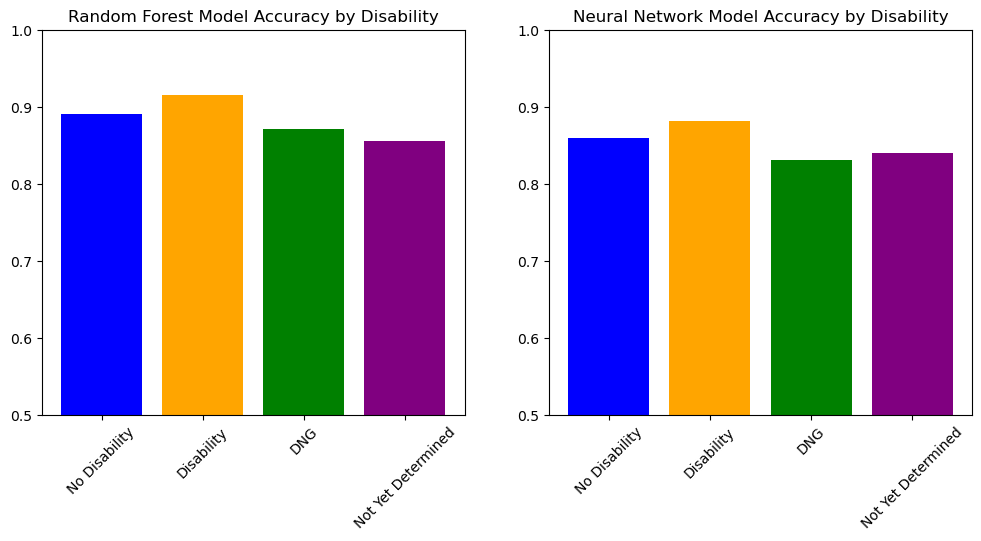

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

labels = ['No Disability', 'Disability', 'DNG', 'Not Yet Determined']
colors = ['blue', 'orange', 'green', 'purple']

# Random Forest
rf_accuracies = [rf_accuracy_no.mean(), rf_accuracy_yes.mean(), rf_accuracy_dng.mean(), rf_accuracy_nyd.mean()]

axs[0].bar(labels, rf_accuracies, color=colors)
axs[0].set_title('Random Forest Model Accuracy by Disability')
axs[0].set_ylim(.5, 1)
axs[0].set_xticklabels(labels, rotation=45)

# Neural Net
nn_accuracies = [nn_accuracy_no.mean(), nn_accuracy_yes.mean(), nn_accuracy_dng.mean(), nn_accuracy_nyd.mean()]
axs[1].bar(labels, nn_accuracies, color=colors)
axs[1].set_title('Neural Network Model Accuracy by Disability')
axs[1].set_ylim(.5, 1)
axs[1].set_xticklabels(labels, rotation=45)

# Display the plots
plt.show()


In [66]:
# Test the final Random Forest model

# Test Accuracy
print('Test Accuracy : ', 
      metrics.accuracy_score(y_test,
                             rf.predict(X_test))*100)

# Classification report
print('Classification Report, Test:\n', classification_report(y_test, rf.predict(X_test)))

Test Accuracy :  88.37237141375044
Classification Report, Test:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89     27899
           1       0.84      0.91      0.87     22223

    accuracy                           0.88     50122
   macro avg       0.88      0.89      0.88     50122
weighted avg       0.89      0.88      0.88     50122

